Start by importing the necessary Python packages, including flowgatenist:

In [1]:
import glob #filenames and pathnames utility
import os   #operating sytem utility

import flowgatenist.batch_process as batch_p

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import pickle

import seaborn as sns
sns.set()

%load_ext autoreload
%autoreload 2

%matplotlib inline

<br>
Indicate the directories where this notebook and the data are located:

In [2]:
notebook_directory = os.getcwd()
notebook_directory

'C:\\Users\\djross\\Documents\\Python Scripts\\flowgatenist\\example data\\Jupyter notebooks'

In [3]:
data_directory = notebook_directory[:notebook_directory.rfind("\\")]
os.chdir(data_directory)
data_directory

'C:\\Users\\djross\\Documents\\Python Scripts\\flowgatenist\\example data'

The layout_file is a .csv file generated by our automation system that has information about the samples in each well of the 96-well plate used for the cytometry samples:

In [4]:
layout_file = glob.glob('*cytom*.csv')[0]
layout_file

'cytom-plate.csv'

In [5]:
plate_layout_0 = pd.read_csv(layout_file).dropna()
plate_layout = plate_layout_0[plate_layout_0['strain']!="none"].copy()

In [6]:
plate_layout['sample'] = [ p for p in plate_layout['plasmid'] ]
plate_layout['sample'] += [ '-' + str(i) + '_' for i in plate_layout['inducerConcentration']]
plate_layout['sample'] += [ w for w in plate_layout['well']]

In [7]:
plate_layout

,position,well,row,column,inducerId,inducerConcentration,inducerUnits,strain,plasmid,sample
1,2,B1,B,1,IPTG,0,umol/L,MG1655-dLac,pVER-IPTG-005,pVER-IPTG-005-0_B1
4,10,B2,B,2,IPTG,2,umol/L,MG1655-dLac,pVER-IPTG-005,pVER-IPTG-005-2_B2
7,18,B3,B,3,IPTG,4,umol/L,MG1655-dLac,pVER-IPTG-005,pVER-IPTG-005-4_B3
10,26,B4,B,4,IPTG,8,umol/L,MG1655-dLac,pVER-IPTG-005,pVER-IPTG-005-8_B4
13,34,B5,B,5,IPTG,16,umol/L,MG1655-dLac,pVER-IPTG-005,pVER-IPTG-005-16_B5
16,42,B6,B,6,IPTG,32,umol/L,MG1655-dLac,pVER-IPTG-005,pVER-IPTG-005-32_B6
19,50,B7,B,7,IPTG,64,umol/L,MG1655-dLac,pVER-IPTG-005,pVER-IPTG-005-64_B7
22,58,B8,B,8,IPTG,128,umol/L,MG1655-dLac,pVER-IPTG-005,pVER-IPTG-005-128_B8
25,66,B9,B,9,IPTG,256,umol/L,MG1655-dLac,pVER-IPTG-005,pVER-IPTG-005-256_B9
28,74,B10,B,10,IPTG,512,umol/L,MG1655-dLac,pVER-IPTG-005,pVER-IPTG-005-512_B10


Next, read in the cytometry data:

In [8]:
plate_layout['coli_file'] = [ glob.glob('*' + w + '.fcs_pkl')[0] for w in plate_layout['well'] ]

max_points = 30000
coli_data = []

for file in plate_layout['coli_file']:
    data = pickle.load(open(file, 'rb'))
    data.flow_frame = data.flow_frame[:max_points]
    coli_data.append(data)
plate_layout['coli_data'] = coli_data

We also use the blank sample data to estimate the true zero level for the fluorescence signal.<br>

With our cytometry instrument (Attune NxT) , we have found that the distribution of fluorescence signals measured with blank samples best matches the exponentially modified normal distribution (https://en.wikipedia.org/wiki/Exponentially_modified_Gaussian_distribution). So, we estimate the parameters of that distribution using Bayesian inference with pystan for Markov chain Monte Carlo (MCMC) sampling. This is handled automatically by the batch_stan_background_fit() function. The first time you run it, it will start by compling the Stan model (which takes about one minute). After that it will run mopre quickly.

Start batch_stan_background_fit: 2021-08-15 19:13:40
    Fitting background data: 2021-08-15 19:13:41


c:\users\djross\documents\python scripts\flowgatenist\flowgatenist\batch_process.py:270: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump( (model, fit), f )


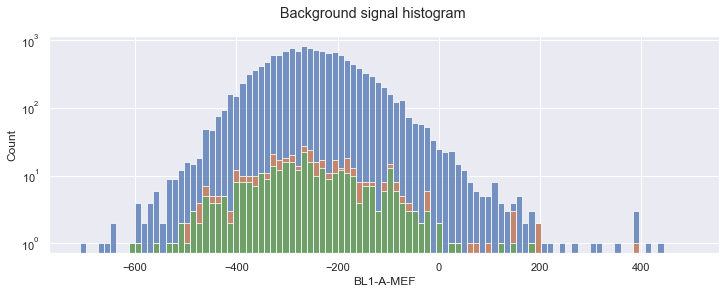

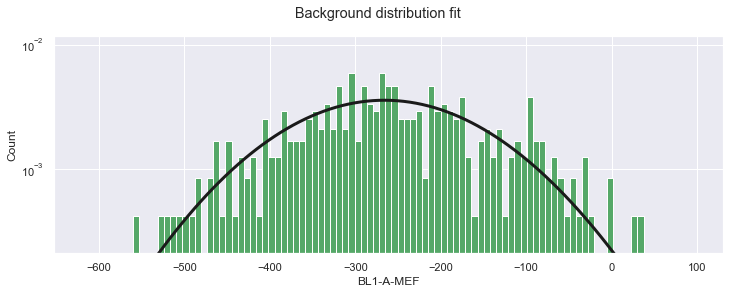

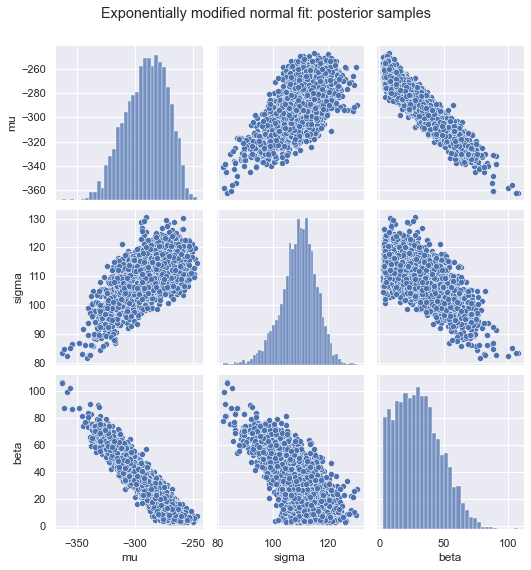

Mean background signal level: -290.10966506267675
                   ... done: 2021-08-15 19:13:59


Inference for Stan model: anon_model_4b5b809d68449c822926da7cad832e43.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
scaled_mu         -0.27  6.9e-3   0.16  -0.59  -0.38  -0.26  -0.15 8.3e-4    541    1.0
scaled_sigma       0.96  2.3e-3   0.06   0.83   0.93   0.96    1.0   1.06    617    1.0
scaled_beta        0.27  6.7e-3   0.15   0.04   0.15   0.26   0.37   0.59    521    1.0
scaled_lambda       6.0    0.26   5.75   1.69   2.67   3.84   6.64  25.04    478    1.0
mu               -290.1    0.78  18.15 -326.7 -302.7 -288.8 -276.3 -259.4    541    1.0
sigma            109.25    0.26   6.55  94.96 105.56 109.69 113.61 120.83    617    1.0
beta              30.91    0.76  17.26   4.54  17.12  29.59  42.62   67.4    521    1.0
lamb               0.05  2.3e-3   0.05   0.01   0.02   0.03   0.06   0.22    478    1.0
post_pred_signal -2

In [9]:
stan_back_fit_b = batch_p.batch_stan_background_fit(data_directory=data_directory,
                                                    fl_channel='BL1-A-MEF',
                                                    fit_max=100, fit_min=-600)
stan_back_fit_b

The first plot shows histograms of the background signal for all events (blue), events that passed the automated gate for cells (orange), and events that passed the automated gate for singlet cells (green).

The second plot shows the histogram of the singlet cell events with the best fit line (with parameters given by the posterior mean from the Stan fit).

The third plot is a Seaborn pairsplot of the posterior distribution from the Stan fit

The function also displays the output table from the Stan fit, with the posterior fit parameter means and confidence intervals.

The exponentially modified normal distribution results from an exponentially distributed signal convoluted with normally distributed (Gaussian) noise. So, we estimate the true zero signal level as the mean of the Gaussian noise (the parameter 'mu' in the Stan model).

There is typically a warning from the pystan fit ("...iterations ended with a divergence..."). For more on this warning see: https://mc-stan.org/users/documentation/case-studies/divergences_and_bias.html.<br>
Basically, the warning indicates that even though the fit matches the data fairly well, the uncertainties estimated by the Stan MCMC algorithm might be too small.<br>
The signal levels we are typically concerned with (>10,000 MEF) are much larger than the width of the background distribution, and, in any case, we don't make use of the uncertainty estimates from Stan. So, we typically use the resulting true zero value in spite of the warning:

In [10]:
stan_back_fit_samples = stan_back_fit_b.extract(permuted=True)
back_mu = stan_back_fit_samples['mu'].mean()
back_mu

-290.10966506267675

Alternately, you could use the simple mean of the backgound signal (which is close to the pystan result):

In [11]:
back_file = glob.glob('*blank*.fcs_pkl')[0]
back_data = pickle.load(open(back_file, 'rb'))
df = back_data.flow_frame
df = df[df.is_singlet]
print(df['BL1-A-MEF'].mean())

-257.9426249236826



<br><br>
Plot histograms of calibrated (MEF) data for all of the samples and also calculate the geometric mean signal for singlet events in each sample:

In [12]:
gated_data = [data.flow_frame.loc[data.flow_frame['is_cell']] for data in coli_data]
singlet_data = [data.flow_frame.loc[data.flow_frame['is_singlet']] for data in coli_data]
all_data = [data.flow_frame for data in coli_data]

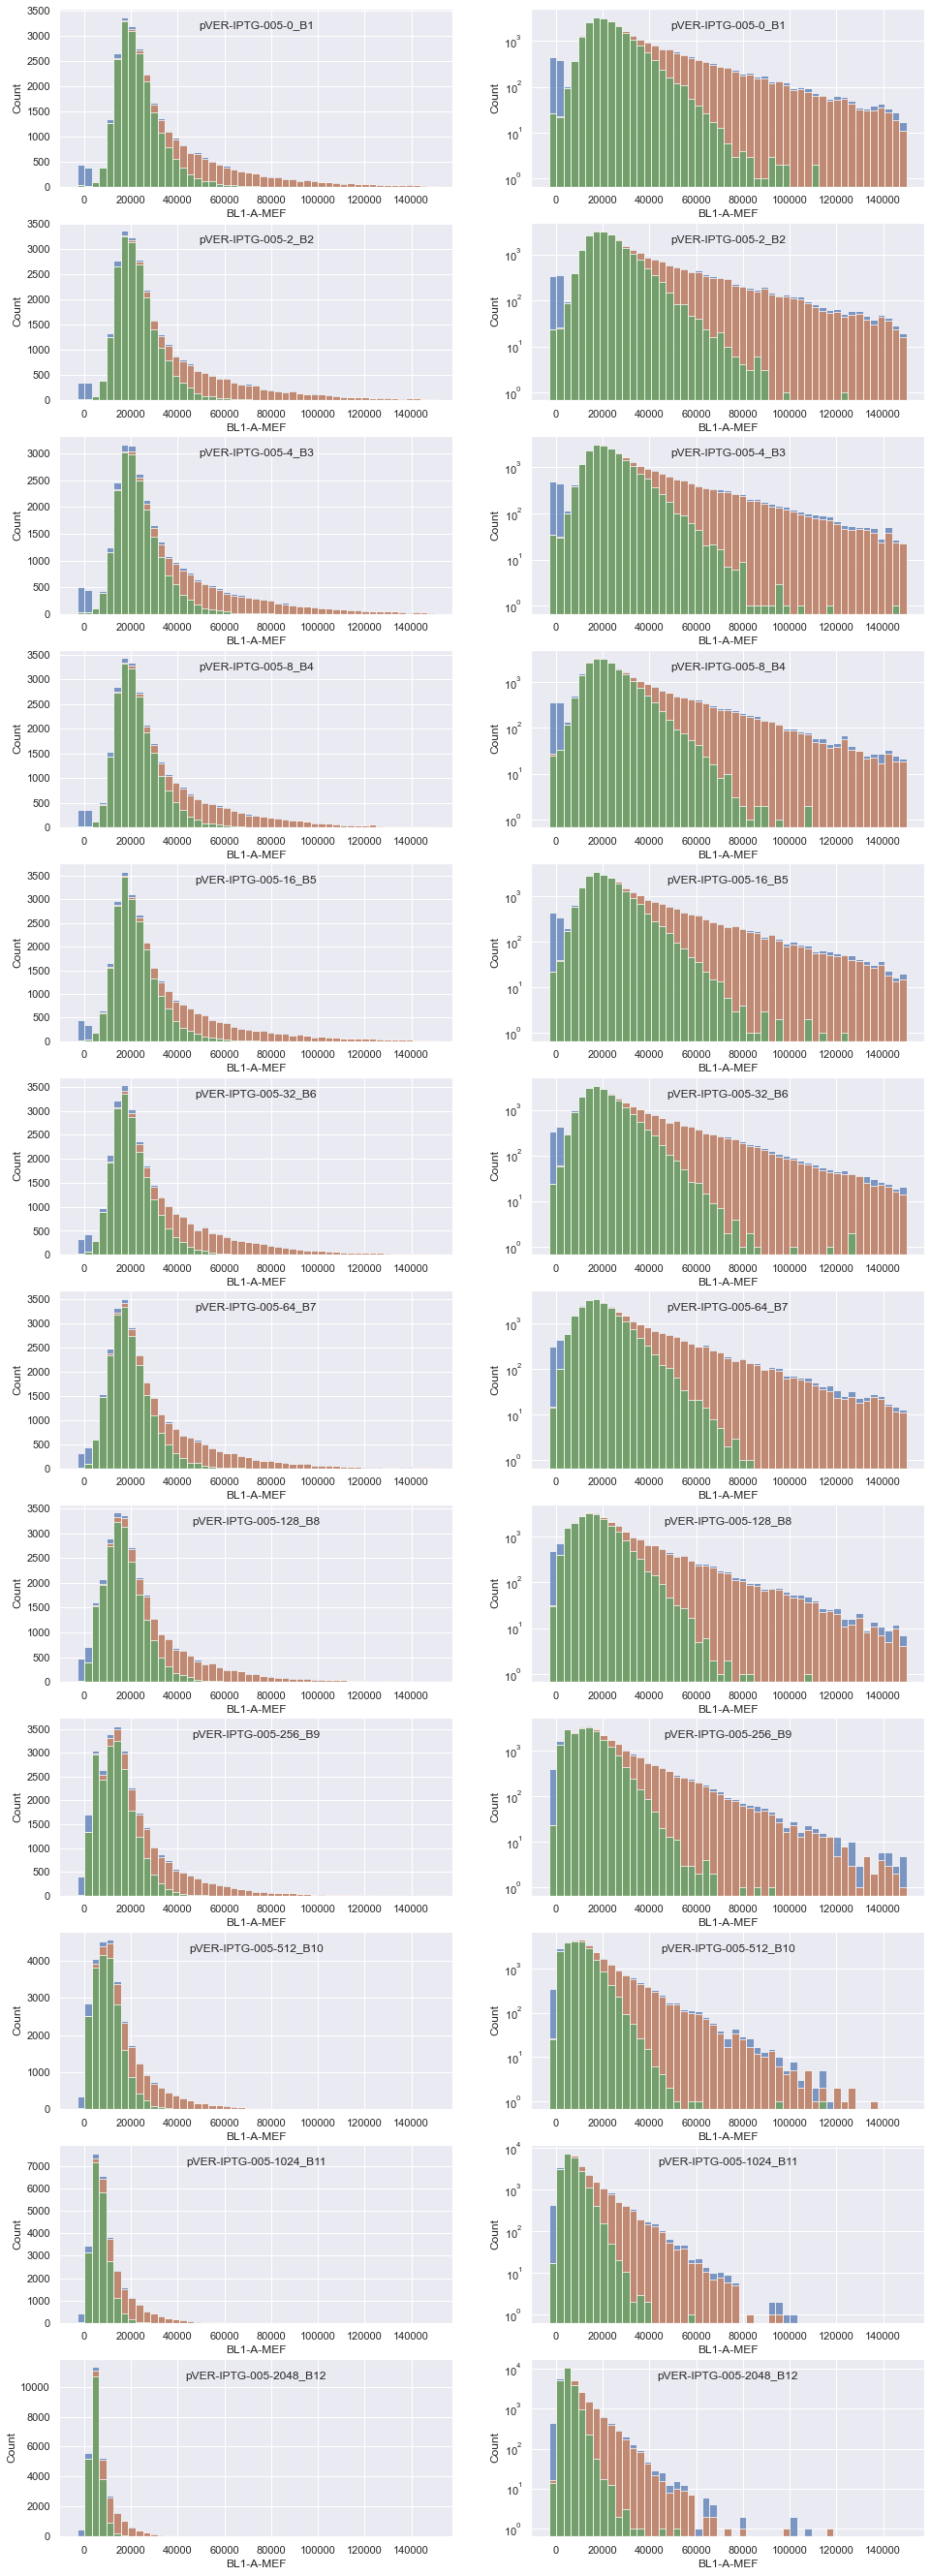

In [13]:
fl_channel = 'BL1-A-MEF'
x_min = -3000
x_max = 150000
alpha = 0.7

geo_mean_list = []
geo_mean_err_list = []
count_list = []

bins = np.linspace(x_min, x_max, 50)

sns.set()
plt.rcParams["figure.figsize"] = [16, 4*len(all_data)]
fig, axs = plt.subplots(len(all_data), 2)
    
for axs_row, data, gated, singlet, samp in zip(axs, all_data, gated_data, singlet_data, plate_layout['sample']):
    axs_row[1].set_yscale('log')
    signal = singlet[fl_channel].copy()
    signal = signal - back_mu
    signal = signal[signal>0]
    geo_mean = np.exp( np.log(signal).mean() )
    geo_mean_err = ( np.log(signal).std() )/( np.sqrt(len(signal)) ) * geo_mean
    geo_mean_list.append(geo_mean)
    geo_mean_err_list.append(geo_mean_err)
    count_list.append(len(signal))
    for ax in axs_row:
        ax.text(0.5, 0.9, samp, horizontalalignment='center', verticalalignment='center',
                transform=ax.transAxes)
        ax.hist(data[fl_channel], bins=bins, alpha=alpha)
        ax.hist(gated[fl_channel], bins=bins, alpha=alpha)
        ax.hist(singlet[fl_channel], bins=bins, alpha=alpha)
        ax.set_xlabel(fl_channel)
        ax.set_ylabel('Count');

<br><br>
Then plot the dose-response curves (geometric mean vs. inducer concentration): 

In [14]:
plate_layout['geo_mean'] = geo_mean_list
plate_layout['geo_mean_err'] = geo_mean_err_list
plate_layout['singlet_count'] = count_list

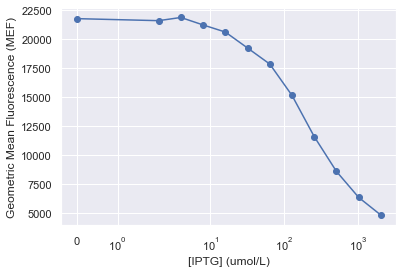

In [15]:
plt.rcParams["figure.figsize"] = [6, 4]

for plas in np.unique(plate_layout.plasmid):
    fig, axs = plt.subplots()
    df = plate_layout[plate_layout.plasmid==plas]
    x = df.inducerConcentration
    y = df.geo_mean
    axs.plot(x, y, '-o');
    axs.set_xscale('symlog')
    axs.set_xlabel(f'[{df.inducerId.iloc[0]}] ({df.inducerUnits.iloc[0]})')
    axs.set_ylabel(f'Geometric Mean Fluorescence (MEF)')